{'tear_rate': {1: 3, 2: {'astigmatic': {1: {'age': {1: 2, 2: 2, 3: {'prescript': {1: 3, 2: 2}}}}, 2: {'prescript': {1: 1, 2: {'age': {1: 1, 2: 3, 3: 3}}}}}}}}


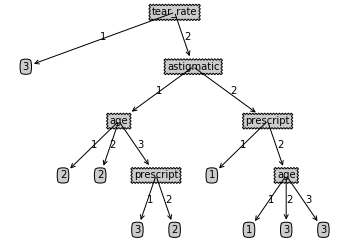

In [57]:
from math import log
import operator
import matplotlib.pyplot as plt
 
class Shannon(): 
    # 计算信息熵
    def clacShannon(data):
        num = len(data)
        # 用于计算每个类别出现的次数，配合num就可以计算该类别的概率了
        label_count = {}
        for feat_vec in data:
            # 向量的最后一个为标签（类别）
            current_label = feat_vec[-1]
            if current_label in label_count.keys():
                label_count[current_label] += 1
            else:
                label_count[current_label] = 1
        entropy = 0.0
        for key in label_count.keys():
            prob = float(label_count[key]) / num
            entropy -= prob * log(prob, 2)
        return entropy
 
 
    # 划分数据集
    # data 需要划分的数据，双重列表[[],[],……,[]]
    # axis 划分的特征
    # value 上述axis的值
    def splitData(data, axis, value):
        result = []
        for feature_vec in data:
            if feature_vec[axis] == value:
                # 将符合条件的实例加入到result中（并去除了相应的特征）
                # result.append(feature_vec[:axis].extend(feature_vec[axis + 1:]))
                reduce_feat = feature_vec[:axis]
                reduce_feat.extend(feature_vec[axis+1:])
                result.append(reduce_feat)
        return result
 
 
    # 选择分类效果最好的特征
    def chooseFeature(data):
        num_data = len(data)
        num_feature = len(data[0]) - 1
        # 原始数据的香农熵
        base_entropy = Shannon.clacShannon(data)
        # 信息增益
        best_info_gain = 0.0
        # 分类效果最好的特征
        best_feature = -1
        # 计算各个特征的信息增益
        for i in range(num_feature):
            # 获取特征i下所有可能的取值,并去重
            feature_list = [example[i] for example in data]
            values = set(feature_list)
            # 新的香农熵
            new_entropy = 0.0
            for value in values:
                sub_data = Shannon.splitData(data, i, value)
                prob = len(sub_data) / float(num_data)
                new_entropy += prob * Shannon.clacShannon(sub_data)
            info_gain = base_entropy - new_entropy
            # 选择分类效果最好--信息增益最大
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = i
        return best_feature
 
 
    # 使用投票机制确定节点的类别
    def majorityCnt(class_list):
        class_count = {}
        for vote in class_list:
            if vote not in class_count.keys():
                class_count[vote] = 0
            class_count[vote] += 1
        # 选取票数最多的作为分类作为该节点的最终类别
        sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_class_count[0][0]
 
 
    # 创建决策树
    # data 数据集，每条记录的最后一项为该实例的类别
    # labels 为了增加结果的可解释性，设定标签
    def createTree(data, labels):
        # data中每条记录的最后一项为该实例的类别
        class_list = [example[-1] for example in data]
        # 结束条件一：该分支下所有记录的类别相同，则为叶子节点，停止分类
        if class_list.count(class_list[0]) == len(class_list):
            return class_list[0]
        # 结束条件二：所有特征使用完毕，该节点为叶子节点，节点类别投票决定
        if len(data[0]) == 1:
            return Shannon.majorityCnt(class_list)
        best_feature = Shannon.chooseFeature(data)
        best_label = labels[best_feature]
        my_tree = {best_label: {}}
        del(labels[best_feature])
        feature_values = [example[best_feature] for example in data]
        unique_values = set(feature_values)
        for value in unique_values:
            sub_lables = labels[:]
            # 递归
            my_tree[best_label][value] = Shannon.createTree(Shannon.splitData(data, best_feature, value), sub_lables)
        return my_tree
 
 
    # 使用决策树进行分类
    # 参数说明：决策树， 标签， 待分类数据
    def classify(input_tree, feature_labels, test_vec):
        first_str = input_tree.keys()[0]
        second_dict = input_tree[first_str]
        # 得到第特征的索引，用于后续根据此特征的分类任务
        feature_index = feature_labels.index(first_str)
        for key in second_dict.keys():
            if test_vec[feature_index] == key:
                if type(second_dict[key]).__name__ == 'dict':
                    classLabel = classify(second_dict[key], feature_labels, test_vec)
                # 达到叶子节点，返回递归调用，得到分类
                else:
                    classLabel = second_dict[key]
        return classLabel
 
 
    # 决策树的存储
    # 决策树的构造是一个很耗时的过程，因此需要将构造好的树保存起来以备后用
    # 使用pickle序列化对象
    def storeTree(input_tree, filename):
        import pickle
        fw = open(filename, "w")
        pickle.dump(input_tree, fw)
        fw.close()
 
 
    # 读取文件中的决策树
    def grabTree(filename):
        import pickle
        fr = open(filename)
        return pickle.load(fr)
class TreePlot():
    
    # 用字典进行存储
    # boxstyle为文本框属性， 'sawtooth'：锯齿型；fc为边框粗细
    decision_node = dict(boxstyle='sawtooth', fc='0.8')
    leaf_node = dict(boxstyle='round4', fc='0.8')
    arrow_args = dict(arrowstyle='<-')
 
 
    # node_txt 要注解的文本，center_pt文本中心点，箭头指向的点，parent_pt箭头的起点
    def plotNode(node_txt, center_pt, parent_pt, node_type):
        TreePlot.createPlot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction',
                                xytext=center_pt, textcoords='axes fraction',
                                va="center", ha="center", bbox=node_type, arrowprops=TreePlot.arrow_args)
    # 创建画板
    def createPlot(in_tree):
        # figure创建画板，‘1’表示第一个图，背景为白色
        fig = plt.figure(1, facecolor='white')
        # 清空画板
        fig.clf()
        axprops = dict(xticks=[], yticks=[])
        # subplot(x*y*z）,表示把画板分割成x*y的网格，z是画板的标号，
        # frameon=False表示不绘制坐标轴矩形
        TreePlot.createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
        # plotNode('decision_node', (0.5, 0.1), (0.1, 0.5), decision_node)
        # plotNode('leaf_node', (0.8, 0.1), (0.8, 0.3),  leaf_node)
        # plt.show()
        # 存储树的宽度
        TreePlot.plotTree.totalW = float(TreePlot.getNumLeafs(in_tree))
        # 存储树的深度
        TreePlot.plotTree.totalD = float(TreePlot.getTreeDepth(in_tree))
        # xOff用于追踪已经绘制的节点的x轴位置信息，为下一个节点的绘制提供参考
        TreePlot.plotTree.xOff = -0.5/TreePlot.plotTree.totalW
        # yOff用于追踪已经绘制的节点y轴的位置信息，为下一个节点的绘制提供参考
        TreePlot.plotTree.yOff = 1.0
        TreePlot.plotTree(in_tree, (0.5, 1.0), '')
        plt.show()
 
 
    # 为了绘制树，要先清楚叶子节点的数量以及树的深度--以便确定x轴的长度和y轴的高度
    # 下面就分别定义这两个方法
    def getNumLeafs(my_tree):
        num_leafs = 0
        first_str = list(my_tree.keys())[0]  # 找到第一个节点
        second_dic = my_tree[first_str]
        # 测试节点数据是否为字典类型，叶子节点不是字典类型
        for key in list(second_dic.keys()):
            # 如果节点为字典类型，则递归使用getNumLeafs()
            if type(second_dic[key]).__name__ == 'dict':
                num_leafs += TreePlot.getNumLeafs(second_dic[key])
            else:
                num_leafs += 1
        return num_leafs
    def getTreeDepth(my_tree):
        max_depth = 0
        first_str = list(my_tree.keys())[0]
        second_dic = my_tree[first_str]
        # 测试节点数据是否为字典类型，叶子节点不是字典类型
        for key in list(second_dic.keys()):
            # 如果节点为字典类型，递归使用getTreeDepth()
            if type(second_dic[key]).__name__ == 'dict':
                this_depth = 1 + TreePlot.getTreeDepth(second_dic[key])
            else:
                # 当节点不为字典型，为叶子节点，深度遍历结束
                # 从递归中调用返回，且深度加1
                this_depth = 1
            # 最大的深度存储在max_depth中
            if this_depth > max_depth:
                max_depth = this_depth
 
        return max_depth
 
 
    # 在父子节点之间填充文本信息进行标注
    # 在决策树中此处应是对应父节点的属性值
    def plotMidText(center_pt, parent_pt, txt_string):
        x_mid = (parent_pt[0] - center_pt[0])/2.0 + center_pt[0]
        y_mid = (parent_pt[1] - center_pt[1])/2.0 + center_pt[1]
        TreePlot.createPlot.ax1.text(x_mid, y_mid, txt_string)
 
 
    def plotTree(my_tree, parent_pt, node_txt):
        num_leafs = TreePlot.getNumLeafs(my_tree)
        depth = TreePlot.getTreeDepth(my_tree)
        first_str = list(my_tree.keys())[0]
        # 以第一次调用为例说明
        # 此时 绘制的为根节点，根节点的x轴：-0.5/plotTree.totalW + (1.0 + float(num_leafs))/2.0/plotTree.totalW
        # 假设整个树中叶子节点的数目为6 则上述根节点的x轴：-0.5/6 + (1 + 6)/2.0/6 = 0.5
        # 实际上，对于根节点而言，下式的值始终是0.5
        center_pt = (TreePlot.plotTree.xOff + (1.0 + float(num_leafs))/2.0/TreePlot.plotTree.totalW, TreePlot.plotTree.yOff)
        TreePlot.plotMidText(center_pt, parent_pt, node_txt)
        TreePlot.plotNode(first_str, center_pt, parent_pt, TreePlot.decision_node)
        second_dict = my_tree[first_str]
        # y轴的偏移--深度优先的绘制策略
        TreePlot.plotTree.yOff -= 1.0 / TreePlot.plotTree.totalD
        for key in list(second_dict.keys()):
            if type(second_dict[key]).__name__ == 'dict':
                TreePlot.plotTree(second_dict[key], center_pt, str(key))
            else:
                TreePlot.plotTree.xOff += 1.0 / TreePlot.plotTree.totalW
                TreePlot.plotNode(second_dict[key], (TreePlot.plotTree.xOff, TreePlot.plotTree.yOff), center_pt, TreePlot.leaf_node)
                TreePlot.plotMidText((TreePlot.plotTree.xOff, TreePlot.plotTree.yOff), center_pt, str(key))
        TreePlot.plotTree.yOff += 1.0 / TreePlot.plotTree.totalD
if __name__ == '__main__':
    a=[]
    with open(r'lenses_data.txt','r') as f:
        for line in f.readlines():
            b = []
            n=0
            for x in line.split():
                if(n!=0):
                    b.append(int(x))
                n += 1
            a.append(b)
    lenses_labels = ['age', 'prescript', 'astigmatic', 'tear_rate']
    lenses_tree = Shannon.createTree(a, lenses_labels)
    print(lenses_tree)
    TreePlot.createPlot(lenses_tree)